In [17]:
import numpy as np
from mylib.dsp.chmm_actions import CHMM
import matplotlib.pyplot as plt
from mylib.statistic_test import *
import igraph
import string
import networkx as ntx

np.random.seed(42)

code_id = '0870 - CSCG Models'
loc = join(figpath, 'Dsp', code_id)
mkdir(loc)
pass

        E:\Data\FinalResults\Dsp\0870 - CSCG Models is already existed!


In [18]:
import igraph
from mylib.dsp.chmm_actions import CHMM

def train_cscg(
    x: np.ndarray | list[np.ndarray], 
    a: np.ndarray, 
    pseudocount: float, 
    n_hidden: int = 50, 
    n_emissions: int = 144,
    n_iter: int = 100,
    term_early: bool = True,
    seed: int = 42
) -> CHMM:
    """
    Train a CHMM model with a simple example.
    """
    n_clones = np.ones(n_emissions, dtype=np.int64) * n_hidden
    
    if isinstance(x, np.ndarray):
        chmm = CHMM(n_clones=n_clones, n_actions=max(a)+1, pseudocount=pseudocount, seed=seed) # Initialize the model
        progress = chmm.learn_em_T(x, a, n_iter=n_iter, term_early=term_early) # Training
    else:
        chmm = CHMM(n_clones=n_clones, n_actions=max(a[0])+1, pseudocount=pseudocount, seed=42) # Initialize the model
        for i in range(len(x)):
            progress = chmm.learn_em_T(x[i], a[i], n_iter=n_iter, term_early=term_early)
    return chmm

def visualize(
    chmm: CHMM, 
    x: np.ndarray, 
    a: np.ndarray, 
    n_hidden: int = 50,
    is_maze_color = True
):
    #chmm.pseudocount = 0.0
    #states = chmm.decode(x, a)[1]
    if isinstance(x, list):
        states = np.concatenate([chmm.decode(xi, ai)[1] for xi, ai in zip(x, a)])
    else:
        states = chmm.decode(x, a)[1]
    chmm.C[:, 143*n_hidden:144*n_hidden, :] = 0
    chmm.C[:, 131*n_hidden:132*n_hidden, :] = 0
    v = np.unique(states)

    num_obs = 8

    if is_maze_color:
        D = GetDMatrices(1, 12)
        dist = D[np.arange(144), 0] / (np.max(D)+ 1e-10)
        vertex_colors = sns.color_palette("rainbow", as_cmap=True)(dist)
        vertex_colors_str = sum([[f'#{int(vertex_colors[i, 0]*255):02x}{int(vertex_colors[i, 1]*255):02x}{int(vertex_colors[i, 2]*255):02x}']*n_hidden for i in range(vertex_colors.shape[0])], [])
    else:
        vertex_colors = np.vstack(sns.color_palette("rainbow", int(chmm.C.shape[1]/n_hidden)))
        vertex_colors_str = sum([[f'#{int(vertex_colors[i, 0]*255):02x}{int(vertex_colors[i, 1]*255):02x}{int(vertex_colors[i, 2]*255):02x}']*n_hidden for i in range(vertex_colors.shape[0])], [])
    
    T = chmm.C[:, v, :][:, :, v]
    A = np.sum(T, axis=0)  # Sum over the first dimension to get the adjacency matrix
    A /= (np.sum(A, axis=1, keepdims=True) + 1e-10)  # Normalize the adjacency matrix
    plt.imshow(A)
    plt.show()
    A[A < 1e-2] = 0  # Threshold the adjacency matrix
    A /= (np.sum(A, axis=1, keepdims=True) + 1e-10)  # Normalize again to ensure rows sum to 1
    del T

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4), gridspec_kw={'width_ratios': [2, 1]})
    ax0 = Clear_Axes(axes[0])
    ax1 = Clear_Axes(axes[1])
    g = igraph.Graph.Adjacency((A > 0).tolist())
    g.es['width'] = 1
    g.es['arrow_size'] = 5
    g.es['arrow_width'] = 5
    
    if is_maze_color:
        for k in np.concatenate([np.arange((CP_DSP[r][0]-1)*n_hidden, CP_DSP[r][0]*n_hidden) for r in range(7)]):
            if k < len(vertex_colors_str):
                vertex_colors_str[k] = '#000000'

    try:
        igraph.plot(g, vertex_color=[vertex_colors_str[i] for i in v], vertex_size=5, target=ax0, layout=g.layout('tree')) # kk, fr, drl, rt, tree
    except:
        pass
    igraph.plot(g, vertex_color=[vertex_colors_str[i] for i in v], vertex_size=5, target=ax1, layout=g.layout('kk')) # kk, fr, drl, rt, tree
    plt.show()
    del g

# Perfect Trajectory Training, 4 Actions ↑ ↓ ← →

Average number of clones: 50.0


  0%|          | 2/1000 [00:08<1:10:30,  4.24s/it, train_bps=7.1] 


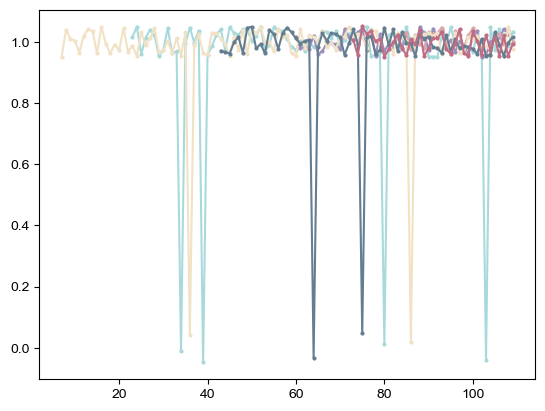

In [3]:
def generate_data(nx: int = 12):
    behav_nodes = []
    actions = []
    routes = []
    for r in range(7):
        behav_nodes.append(CP_DSP[r][:-1])
        action = np.zeros(CP_DSP[r].shape[0]-1, dtype=np.int64)
        for i in range(CP_DSP[r].shape[0]-1):
            if CP_DSP[r][i+1] == CP_DSP[r][i] + 1:
                action[i] = 0
            elif CP_DSP[r][i+1] == CP_DSP[r][i] + nx:
                action[i] = 1
            elif CP_DSP[r][i+1] == CP_DSP[r][i] - 1:
                action[i] = 2
            elif CP_DSP[r][i+1] == CP_DSP[r][i] - nx:
                action[i] = 3

        actions.append(action)
        routes.append(np.repeat(r, action.shape[0]))
    
    return np.concatenate(behav_nodes)-1, np.concatenate(actions), np.concatenate(routes).astype(np.int64)


n_hidden = 50
n_emissions = 143
n_iter = 1000
x, a, rs = generate_data(nx=12)
a = np.zeros_like(x)
chmm = train_cscg(
    x, 
    rs, 
    pseudocount=1e-2, 
    n_hidden=n_hidden, 
    n_emissions=n_emissions, 
    n_iter=n_iter,
    seed=42
)

#visualize(chmm, x, a, n_hidden=n_hidden) 

decoded_hidden_states = [chmm.decode(CP_DSP[r][:-1]-1, np.repeat(r, CP_DSP[r].shape[0]-1).astype(np.int64))[1] for r in range(7)]
for r in range(1, 7):
    _len = CP_DSP[r].shape[0]
    y = np.where(decoded_hidden_states[r]-decoded_hidden_states[0][-(_len-1):] == 0, 0, 1).astype(np.float64)
    y += (np.random.rand(y.shape[0])*0.1-0.05)
    plt.plot(
        np.arange(111)[-CP_DSP[r].shape[0]:-1], 
        y, 
        label=f'Route {r}', 
        marker='o',
        markeredgewidth=0,
        markersize=3,
        color=DSPPalette[r]
    )
plt.show()

# Train by Behavior

In [3]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

dir_template = join(figpath, 'Dsp', '0869 - Detailed Behavioral Analysis', 'template')

def get_hmm_states(
    behav_res_angles: np.ndarray, 
    behav_res_speeds: np.ndarray, 
    behav_speed_traj: np.ndarray,
    behav_lap_traj: np.ndarray
):
    """Use HMM to get behavioral states."""
    # Example data: 1D oscillatory behavior (you may have more features in real data)
    # Simulate some example data: 2 states with different distributions
    # Data: N time steps, observed as 1D feature (you can replace this with real data)

    behav_hidden_states = np.ones_like(behav_res_angles)
    
    observations = np.vstack([
        behav_res_angles,
        behav_res_speeds,
        behav_speed_traj
    ]).T

    fit_idx = np.where(
        (np.isnan(observations[:, 0]) == False) &
        (np.isnan(observations[:, 1]) == False) &
        (np.isnan(behav_speed_traj) == False)
    )[0]
    observations = observations[fit_idx, :]

    fit_lap_traj = behav_lap_traj[fit_idx]
    beg = np.concatenate([[0], np.where(np.diff(fit_lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(fit_lap_traj) != 0)[0]+1, [len(fit_lap_traj)]])
    lengths = end-beg

    # Define the number of hidden states (2 states for low and high amplitude)
    model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, random_state=42)

    # Train the model using the Baum-Welch algorithm (unsupervised)
    model.fit(observations, lengths=lengths)

    # Predict the hidden states for each time point
    hidden_states = model.predict(observations, lengths=lengths)
    
    idx0 = np.where(hidden_states == 0)[0]
    idx1 = np.where(hidden_states == 1)[0]
    
    res0 = np.nanmean(behav_res_angles[fit_idx][idx0])
    res1 = np.nanmean(behav_res_angles[fit_idx][idx1])
    if res0 > res1:
        behav_hidden_states[fit_idx] = 1 - hidden_states
    else:
        behav_hidden_states[fit_idx] = hidden_states
    return behav_hidden_states

def process_behav(mouse: int, session: int):
    with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
        template = pickle.load(f)
        
    file_idx = np.where(f2['MiceID'] == mouse)[0][session]
    
    with open(f2['Trace File'][file_idx], 'rb') as f:
        trace = pickle.load(f)
        
    obs_states = spike_nodes_transform(trace['correct_nodes'], 12)
    
    beg, end = LapSplit(trace, trace['paradigm'])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)
    behav_nodes = spike_nodes_transform(trace['correct_nodes'], 12)
    
    behav_nodes_traj = []
    behav_nodes_son_traj = []
    behav_lap_traj = []
    behav_routes_traj = []
    behav_session_traj = []
    behav_params_traj = []
    behav_params_templ_traj = []
    behav_dt_traj = []
    behav_t_traj = []


    for j in range(len(beg)):
        dp = np.diff(trace['correct_pos'][beg[j]:end[j], :], axis=0)/10
        dt = np.diff(trace['correct_time'][beg[j]:end[j]])/1000
        dl = np.sqrt(dp[:, 0]**2 + dp[:, 1]**2)
        v = dl/dt
        # Moving Direction
        a = np.arctan2(dp[:, 1], dp[:, 0])
        
        params = np.vstack([
            trace['correct_pos'][beg[j]:end[j]-1, :].T/10,
            a,
            v
        ])
        params_templ = template[behav_nodes[beg[j]:end[j]-1]-1, :, routes[j]].T
        
        behav_nodes_traj.append(behav_nodes[beg[j]:end[j]-1])
        behav_nodes_son_traj.append(trace['correct_nodes'][beg[j]:end[j]-1])
        behav_lap_traj.append(np.repeat(j, len(params[0])))
        behav_routes_traj.append(np.repeat(routes[j], len(params[0])))
        behav_session_traj.append(np.repeat(session, len(params[0])))
        behav_params_traj.append(params)
        behav_params_templ_traj.append(params_templ)
        behav_dt_traj.append(dt)
        behav_t_traj.append((trace['correct_time'][beg[j]:end[j]-1] - trace['correct_time'][beg[j]])/1000)
        
    behav_nodes_traj = np.concatenate(behav_nodes_traj)
    behav_nodes_son_traj = np.concatenate(behav_nodes_son_traj)
    behav_lap_traj = np.concatenate(behav_lap_traj)
    behav_routes_traj = np.concatenate(behav_routes_traj)
    behav_session_traj = np.concatenate(behav_session_traj)
    behav_params_traj = np.concatenate(behav_params_traj, axis=1)
    behav_params_templ_traj = np.concatenate(behav_params_templ_traj, axis=1)
    behav_dt_traj = np.concatenate(behav_dt_traj)
    behav_t_traj = np.concatenate(behav_t_traj)

    behav_res_angles = behav_params_traj[2, :] - behav_params_templ_traj[2, :]
    behav_res_angles[behav_res_angles > np.pi] = 2*np.pi - behav_res_angles[behav_res_angles > np.pi]
    behav_res_angles[behav_res_angles < -np.pi] = -2*np.pi - behav_res_angles[behav_res_angles < -np.pi]
    behav_res_angles = np.rad2deg(np.abs(behav_res_angles))
    behav_res_speeds = behav_params_traj[3, :] - behav_params_templ_traj[3, :]

    def gaussian_kernel(x, sigma):
        return np.exp(-x**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

    beg = np.concatenate([[0], np.where(np.diff(behav_lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(behav_lap_traj) != 0)[0]+1, [len(behav_lap_traj)]])
    for i in range(len(beg)):
        gkernel = gaussian_kernel(np.linspace(-5, 5, 11), sigma=1)
        gkernel /= np.sum(gkernel)
        behav_res_angles[beg[i]:end[i]] = np.convolve(behav_res_angles[beg[i]:end[i]], gkernel, mode='same')
        behav_res_speeds[beg[i]:end[i]] = np.convolve(behav_res_speeds[beg[i]:end[i]], gkernel, mode='same')
    behav_hidden_states = get_hmm_states(
        behav_res_angles,   
        behav_res_speeds,
        behav_params_traj[3, :],
        behav_lap_traj
    ).astype(np.int64)
    
    is_deleted = np.zeros_like(behav_nodes_traj)
    for i in range(len(behav_nodes_traj)-1):
        if behav_nodes_traj[i+1] == behav_nodes_traj[i]:
            is_deleted[i+1] = 1  
    return behav_nodes_traj.astype(np.int64)[is_deleted==0]-1, behav_hidden_states[is_deleted==0]

def generate_data2(nx: int = 12):
    behav_nodes = []
    actions = []
    routes = []
    prertrv = [0, 4, 10, 26, 4, 12, 8]
    for r in range(7):
        behav_nodes.append(CP_DSP[r][:-1])
        action = np.ones(CP_DSP[r].shape[0]-1, dtype=np.int64)
        action[:prertrv[r]] = 0  # No action for the first few nodes

        actions.append(action)
        routes.append(np.repeat(r, action.shape[0]))
    
    return np.concatenate(behav_nodes)-1, np.concatenate(actions), np.concatenate(routes).astype(np.int64)

n_hidden = 20
n_emissions = 144
n_iter = 2
x, a, rs = generate_data2(nx=12)
chmm = train_cscg(x, a, pseudocount=1e-15, n_hidden=n_hidden, n_emissions=n_emissions, n_iter=n_iter)
#visualize(chmm, x, a, n_hidden=n_hidden)
#decoded_hidden_states = [chmm.decode(CP_DSP[r][:-1]-1, np.zeros(CP_DSP[r].shape[0]-1, dtype=np.int64))[1] for r in range(7)]
decoded_hidden_states = [chmm.decode(CP_DSP[r][:-1]-1, np.repeat(r, CP_DSP[r].shape[0]-1).astype(np.int64))[1] for r in range(7)]
for r in range(1, 7):
    _len = CP_DSP[r].shape[0]
    y = np.where(decoded_hidden_states[r]-decoded_hidden_states[0][-(_len-1):] == 0, 0, 1).astype(np.float64)
    y += (np.random.rand(y.shape[0])*0.1-0.05)
    plt.plot(
        np.arange(111)[-CP_DSP[r].shape[0]:-1], 
        y, 
        label=f'Route {r}', 
        marker='o',
        markeredgewidth=0,
        markersize=3,
        color=DSPPalette[r]
    )
plt.show()

Average number of clones: 20.0


100%|██████████| 2/2 [00:03<00:00,  1.83s/it, train_bps=0.0391]


AssertionError: 

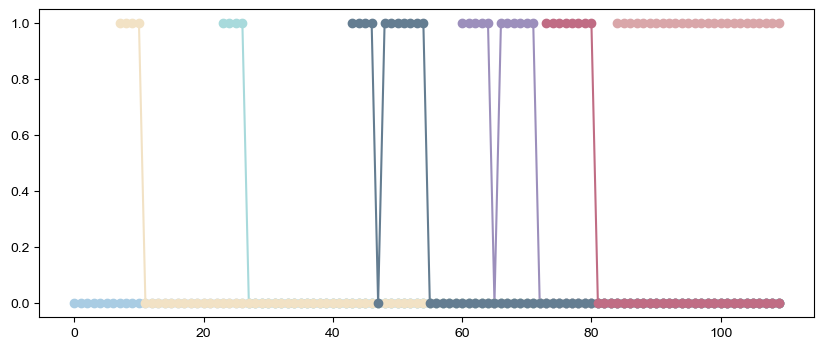

In [51]:
fig = plt.figure(figsize=(10, 4))
states0 = chmm.decode(x[rs == 0], a[rs == 0])[1]
template_res = states0 - (CP_DSP[0][:-1]-1)*n_hidden
for r in range(7):
    _len = CP_DSP[r].shape[0]
    states = chmm.decode(x[rs == r], a[rs == r])[1]
    res = states - (CP_DSP[r][:-1]-1)*n_hidden
    plt.plot(np.arange(111)[-_len:-1], np.where(np.abs(res - template_res[-res.shape[0]:]) == 0, 0, 1), 'o-', color=DSPPalette[r], label=f'Route {r+1}')

# Introduce Confused Cues for Maze 1

In [46]:
n_hidden = 20
n_emissions = 15
n_iter = 500
x = [np.array([0, 1, 2, 6, 7, 8, 9, 10, 11, 12]), np.array([3, 4, 5, 6, 7, 8, 9, 13, 14, 15])]
a = [np.zeros_like(x[0]), np.zeros_like(x[1])]
print(x, a)
x = np.concatenate(x)
a = np.concatenate(a)

[array([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 12]), array([ 3,  4,  5,  6,  7,  8,  9, 13, 14, 15])] [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


Average number of clones: 20.0


100%|██████████| 500/500 [00:01<00:00, 323.59it/s, train_bps=0.245]


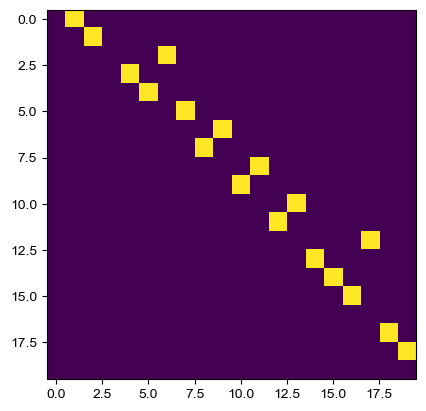

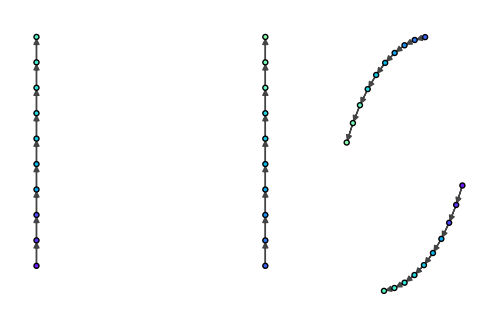

[ 16  36  48 125 159 168 191 215 238 250]
[ 79  96 119 123 150 175 190 274 291 300]


In [47]:
chmm = train_cscg(x, a, pseudocount=1e-8, n_hidden=n_hidden, n_emissions=n_emissions*2, n_iter=n_iter)
chmm.C[0][np.ix_(np.arange(x[9]*n_hidden, (x[9]+1)*n_hidden), np.arange(x[10]*n_hidden, (x[10]+1)*n_hidden))] = 0
#chmm.C[0][np.ix_(np.arange(x[n_emissions-1]*n_hidden, (x[n_emissions-1]+1)*n_hidden), np.arange(x[n_emissions]*n_hidden, (x[n_emissions]+1)*n_hidden))] = 0
#chmm.C[0][np.arange(x[n_emissions*2-1]*n_hidden, (x[n_emissions*2-1]+1)*n_hidden), :] = 0
#chmm.C[1][np.ix_(np.arange(x[9]*n_hidden, (x[9]+1)*n_hidden), np.arange(x[10]*n_hidden, (x[10]+1)*n_hidden))] = 0
visualize(chmm, [x[0:n_emissions], x[n_emissions:2*n_emissions]], [a[0:n_emissions], a[n_emissions:2*n_emissions]], n_hidden=n_hidden, is_maze_color=False) 
print(chmm.decode(x[:10], a[:10])[1])
print(chmm.decode(x[10:], a[10:])[1])

In [4]:
def get_graphs():
    G = np.zeros((7, 144, 144))
    for r in range(7):
        with open(join(loc, f'structured_graph_r{r}.pkl'), 'rb') as f:
            G[r] = pickle.load(f)
            
    return G

def process_data(trace):
    G = get_graphs()
    # Process the trace data using the graph G
    
    behav_nodes = spike_nodes_transform(trace['correct_nodes'], 12)
    beg, end = LapSplit(trace, trace['paradigm'])
    route = classify_lap(behav_nodes, beg)
    
    for r in range(1, 7):
        pass
    
    

In [ ]:
G = get_graphs()
with open(join(loc, 'G.pkl'), 'wb') as f:
    pickle.dump(G, f)

[0 1 2 3 4 5]
Average number of clones: 100.0


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:30<00:00,  3.31it/s, train_bps=0.209]


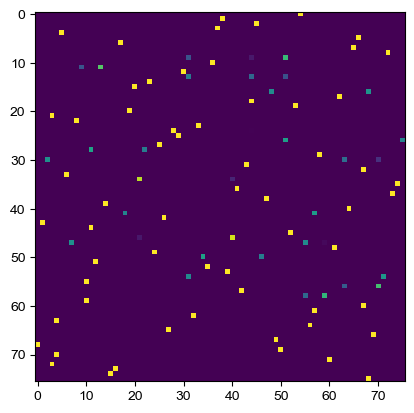

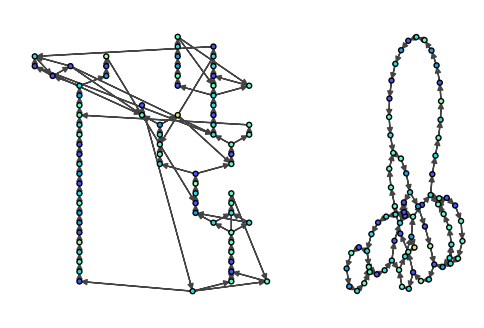

In [16]:
n_hidden = 100
n_emissions = 8
n_iter = 100

G = get_graphs()
cue_x, cue_y = CP_DSP[0][:-1]-1, CP_DSP[0][1:] - 1
x1 = np.concatenate([G[0][(cue_x, cue_y)]] * 50).astype(np.int64)-1
print(np.unique(x1))
a1 = np.zeros_like(x1)

x = x1
a = a1

chmm = train_cscg(x, a, pseudocount=1e-3, n_hidden=n_hidden, n_emissions=n_emissions, n_iter=n_iter, term_early=True, seed=42)
visualize(
    chmm, 
    x[:cue_x.shape[0]], a[:cue_x.shape[0]],
    n_hidden=n_hidden,
    is_maze_color=False
)


In [8]:
print(chmm.C.shape)

(1, 5500, 5500)
